# Chapter06 ゲート付きRNN

---

## 前準備

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


from common.base_model import BaseModel
from common.functions import sigmoid
from common.time_layers import *
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

## RNNの問題点

- RNNは時系列データの長期の依存関係を学習することが苦手
  - BPTT(Backpropagation Through Time)が勾配消失もしくは勾配爆発を起こすため
    - 勾配消失の原因: $y = \tanh(x)$の微分$\frac{\partial y}{\partial x} = 1 - y^2$となり, 時間を経る度に1より小さい数が乗算される
    - 勾配爆発の原因: MatMulを通るたびに重みをT回乗算するために起こる

- 勾配爆発は勾配クリッピングによって対策が出来る(以下は擬似コード)
  - $\|\hat{g}\|$が$threshold$を超えた場合に勾配の修正を行うというもの
$$
\mathrm{if} \quad \|\hat{g}\| \geq threshold: \\
\hat{g} = \dfrac{threshold}{\|\hat{g}\|}\hat{g}
$$

- $threshold$: 閾値
$\hat{g}$: NNで使用される全てのパラメータの勾配を一つにまとめたもの

In [ ]:
def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)

    rate = max_norm / (total_norm + 1e-6)
    if rate < 1:
        for grad in grads:
            grad *= rate

## 勾配消失とLSTM

- 勾配消失問題を解決するにはアーキテクチャを根本から変える必要がある
  - その1つがゲート付きRNN
    - 代表的手法にLSTMとGRUがあるが, 本章ではLSTMに焦点を当てる
    
- RNNとLSTMの違いとしてLSTMには記憶セルが存在する
  - この記憶セルはLSTMレイヤ内で完結するため他のレイヤへ出力しない
  - 現在の記憶セル$c_t$は3つの入力($c_{t-1}, h_{t_1}, x_t$)から後述していく計算によって求められる
  - 更新された$c_t$を使用して隠れ状態$h_t$が計算される
    - この計算は$h_t = \tanh(c_t)$によって$c_t$の各要素に対し$\tanh$関数を適用する

- LSTMにはゲートという機能がある
  - データの流れをコントロールする
  - 「output」「forget」「input」の3種類のゲートが存在する

---

- 入力データに対し, ゲートは以下の順で動作を行い, $h_t$を出力する
  - forgetゲート: 記憶セル$c_{t-1}$に対し何を忘れるかを指示するゲート
    - このままでは忘れただけで新しい情報$\mathrm{g}$を記憶セルに追加する
  - inputゲート: $\mathrm{g}$の各要素が新たに追加する情報としてどれだけ価値があるかを判断する(追加情報の取捨選択)
  - outputゲート: $\tanh(c_t)$の各要素に対し, 「それらが次時刻の隠れ状態としてどれだけ重要か」を調整するゲート

- 上記の4工程を式に表すと以下となる
  - forgetゲート: $\mathrm{f} = \sigma(x_t W_x^{(\mathrm{f})} + h_{t-1}W_h^{(\mathrm{f})} + b^{(\mathrm{f})})$
  - 情報の追加: $\mathrm{g} = \tanh(x_t W_x^{(\mathbf{g})} + h_{t-1}W_h^{(\mathbf{g})} + b^{(\mathrm{g})})$
  - inputゲート: $\mathrm{i} = \sigma(x_t W_x^{(\mathrm{i})} + h_{t-1}W_h^{(\mathrm{i})} + b^{(\mathrm{i})})$
  - outputゲート: $\mathrm{o} = \sigma(x_t W_x^{(\mathrm{o})} + h_{t-1}W_h^{(\mathrm{o})} + b^{(\mathrm{o})})$
  
- forgetゲート, 追加情報, inputゲートの3つの出力と前の時刻の記憶セル$c_{t-1}$によって現時刻の記憶セル$c_t$を求められる
  - $c_t = \mathrm{f} \odot c_{t-1} + \mathrm{g} \odot \mathrm{i}$
- outputゲートの出力$\mathrm{o}$に対し$\tanh(c_t)$とのアダマール積を計算し$h_t$を求める事ができる
  - $h_t = \mathrm{o} \odot \tanh(c_t)$
- RNNの逆伝播では同じ重みと行列を使用した「行列の積」を繰り返し行っていたが, LSTMの逆伝播では「要素ごとの積」を毎時刻, 異なるゲート値によって行うため勾配消失が起こりにくい

---

## LSTMの実装

- forget ~ outputまでの4つの式はいずれも関数内で$xW_x+hW_h+b$の形状をとっている為, 以下のような計算を行ったほうが計算を高速化することができる
$$
x_t[W_x^{(\mathrm{f})} \quad W_x^{(\mathrm{g})} \quad W_x^{(\mathrm{i})} \quad W_x^{(\mathrm{o})}] + h_{t-1}[W_h^{(\mathrm{f})} \quad W_h^{(\mathrm{g})} \quad W_h^{(\mathrm{i})} \quad W_h^{(\mathrm{o})}] + [b^{(\mathrm{f})} \quad b^{(\mathrm{g})} \quad b^{(\mathrm{i})} \quad b^{(\mathrm{o})}] \\
= x_tW_x + h_{t-1}W_h + b
$$

In [ ]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        # Wx, Wh, bには4つ分の重み, バイアスがまとめられている
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H: 3*H]
        o = A[:, 3*H:]
        
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    def backward(self, dh_next, dc_next):
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        tanh_c_next = np.tanh(c_next)
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        dc_prev = ds * f
        
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= g * (1 - g ** 2)
        
        dA = np.hstack((df, dg, di, do))
        
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        return dx, dh_prev, dc_prev

---

### TimeLSTMの実装

- T個分の時系列データをまとめて処理するレイヤ
  - T個のLSTMレイヤによって構成される
  
 - Truncated BPTTは逆伝播のつながりを適当な長さで断ち切り, 順伝播の流れは維持する必要がある
   - なので隠れ状態と記憶セルをメンバ変数に保持させるようにすることで次のforward()が呼ばれた際に, 前時刻の隠れ状態と記憶セルから開始することができる

In [ ]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            hs[:, t, :] = self.h

            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        dxs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0

        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh
        return dxs

    def set_state(self, h, c=None):
        self.h, self.c = h, c

    def reset_state(self):
        self.h, self.c = None, None

---

## LSTMを使った言語モデル

- 前章のTimeRNNレイヤの場所にTimeLSTMレイヤを使用する
  - ネットワーク構成に関してはChpter05.ipynbを参照

In [ ]:
class Rnnlm:
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4*H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]
        
        # 全ての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
            
    # 7章で使用するメソッド
    # 本章では使用しないため不要だが一応掲載
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.lstm_layer.reset_state()
    
    def save_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'wb') as f:
            pickle.dump(self.params, f)
    
    def load_params(self, file_name='Rnnlm.pkl'):
        with open(file_name, 'rb') as f:
            self.params = pickle.load(f) 

---

### PTBデータセットの学習

- 前章と異なりPTBデータセットの訓練データすべてを使って学習をする

| epoch 1 |  iter 1 / 1327 | time 0[s] | perplexity 10000.57
| epoch 1 |  iter 21 / 1327 | time 7[s] | perplexity 2333.09
| epoch 1 |  iter 41 / 1327 | time 14[s] | perplexity 1302.65
| epoch 1 |  iter 61 / 1327 | time 21[s] | perplexity 1099.69
| epoch 1 |  iter 81 / 1327 | time 28[s] | perplexity 958.64
| epoch 1 |  iter 101 / 1327 | time 35[s] | perplexity 837.38
| epoch 1 |  iter 121 / 1327 | time 42[s] | perplexity 833.66
| epoch 1 |  iter 141 / 1327 | time 49[s] | perplexity 789.58
| epoch 1 |  iter 161 / 1327 | time 56[s] | perplexity 707.46
| epoch 1 |  iter 181 / 1327 | time 63[s] | perplexity 709.23
| epoch 1 |  iter 201 / 1327 | time 70[s] | perplexity 625.92
| epoch 1 |  iter 221 / 1327 | time 77[s] | perplexity 606.73
| epoch 1 |  iter 241 / 1327 | time 84[s] | perplexity 544.74
| epoch 1 |  iter 261 / 1327 | time 91[s] | perplexity 577.84
| epoch 1 |  iter 281 / 1327 | time 98[s] | perplexity 547.05
| epoch 1 |  iter 301 / 1327 | time 105[s] | perplexity 487.14
| epoch 1 

| epoch 2 |  iter 1261 / 1327 | time 907[s] | perplexity 167.83
| epoch 2 |  iter 1281 / 1327 | time 914[s] | perplexity 168.60
| epoch 2 |  iter 1301 / 1327 | time 921[s] | perplexity 210.62
| epoch 2 |  iter 1321 / 1327 | time 929[s] | perplexity 202.01
| epoch 3 |  iter 1 / 1327 | time 931[s] | perplexity 214.90
| epoch 3 |  iter 21 / 1327 | time 938[s] | perplexity 200.21
| epoch 3 |  iter 41 / 1327 | time 945[s] | perplexity 188.94
| epoch 3 |  iter 61 / 1327 | time 952[s] | perplexity 174.09
| epoch 3 |  iter 81 / 1327 | time 959[s] | perplexity 159.34
| epoch 3 |  iter 101 / 1327 | time 966[s] | perplexity 146.68
| epoch 3 |  iter 121 / 1327 | time 973[s] | perplexity 160.15
| epoch 3 |  iter 141 / 1327 | time 980[s] | perplexity 171.15
| epoch 3 |  iter 161 / 1327 | time 987[s] | perplexity 190.90
| epoch 3 |  iter 181 / 1327 | time 995[s] | perplexity 201.86
| epoch 3 |  iter 201 / 1327 | time 1002[s] | perplexity 190.68
| epoch 3 |  iter 221 / 1327 | time 1009[s] | perplexity

| epoch 4 |  iter 1141 / 1327 | time 1812[s] | perplexity 134.92
| epoch 4 |  iter 1161 / 1327 | time 1819[s] | perplexity 127.48
| epoch 4 |  iter 1181 / 1327 | time 1826[s] | perplexity 127.70
| epoch 4 |  iter 1201 / 1327 | time 1833[s] | perplexity 113.46
| epoch 4 |  iter 1221 / 1327 | time 1840[s] | perplexity 101.33
| epoch 4 |  iter 1241 / 1327 | time 1847[s] | perplexity 126.34
| epoch 4 |  iter 1261 / 1327 | time 1854[s] | perplexity 124.97
| epoch 4 |  iter 1281 / 1327 | time 1861[s] | perplexity 121.14
| epoch 4 |  iter 1301 / 1327 | time 1869[s] | perplexity 149.47
| epoch 4 |  iter 1321 / 1327 | time 1876[s] | perplexity 147.44


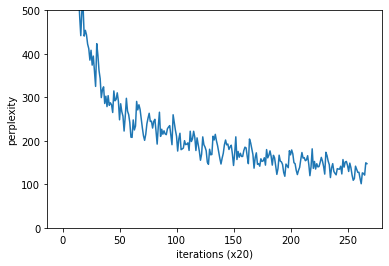

evaluating perplexity ...
234 / 235
test perplexity:  153.9599240830437


In [33]:
# ハイパーパラメータ
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 35
lr = 20.0
max_epoch = 4
max_grad = 0.25

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# モデルの生成
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# 勾配クリッピングを適用して学習
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad, eval_interval=20)
trainer.plot(ylim=(0, 500))

# テストデータで取得
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

# パラメータの保存
model.save_params()

- <code>RnnlmTrainer</code>クラスによる学習
  - <code>fit()</code>メソッドでモデルの勾配を求め, モデルのパラメータを更新する
  - 引数<code>max_grad</code>の指定によって勾配クリッピングが適用される
  
---

## RNNLMのさらなる改善

1. LSTMレイヤの多層化
  - ここまでは1層のLSTMレイヤだが複数層重ねることで精度向上が期待できる
  - 適切な層数に関してはハイパーパラメータであるため取り組む問題の難解さ等で異なってくる
    - 参考までにPTBデータセットにおいては2~4程度が良い
2. Dropoutによる過学習の抑制
  - 画像認識等に用いられるようなCNN同様ランダムにニューロンを選び, そのニューロンを無視する
  - 差し込むには時間軸方向ではなく深さ方向に行うべき
    - 時間軸方向に差し込むと時間の進行と比例してDropoutによるノイズが蓄積するため
3. 重み共有
  - EmbeddingレイヤとAffineレイヤの重みを共有するテクニック
    - 学習パラメータの削減と精度向上が期待できる
    - 語彙数$V$, LSTMの隠れ状態の次元数を$H$とした時, Embedding, Affineのそれぞれのレイヤの重み形状は$(V \times H), (H \times V)$となる
      - なのでEmbeddingレイヤの重みの転置をAffineレイヤに適用することで共有が可能となる


- 上記の改善点を踏まえて実装を行う

In [40]:
class BetterRnnlm(BaseModel):
    def __init__(self, vocab_size=10000, wordvec_size=650, hidden_size=650, dropout_ratio=0.5):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx1 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh1 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b1 = np.zeros(4*H).astype('f')
        lstm_Wx2 = (rn(D, 4*H) / np.sqrt(D)).astype('f')
        lstm_Wh2 = (rn(H, 4*H) / np.sqrt(H)).astype('f')
        lstm_b2 = np.zeros(4*H).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # 改善
        self.layers = [
            TimeEmbedding(embed_W),
            TimeDropout(dropout_ratio),  # Dropout層の追加
            TimeLSTM(lstm_Wx1, lstm_Wh1, lstm_b1, stateful=True),
            TimeDropout(dropout_ratio),
            TimeLSTM(lstm_Wx2, lstm_Wh2, lstm_b2, stateful=True),  # LSTMレイヤの追加
            TimeDropout(dropout_ratio),
            TimeAffine(embed_W.T, affine_b) # 重み共有
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layers = [self.layers[2], self.layers[4]]
        self.drop_layers = [self.layers[1], self.layers[3], self.layers[5]]
        
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
    
    def predict(self, xs, train_fig=False):
        for layer in self.drop_layers:
            layer.train_fig = train_fig
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs
    
    def forward(self, xs, ts, train_flg=True):
        score = self.predict(xs, train_flg)
        loss = self.loss_layer.forward(score, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        for layer in self.lstm_layers:
            layer.reset_state()

---

### 学習

In [ ]:
from common import config
# GPUで実行しない場合は下記をコメントアウト
# GPUを使わない場合後に出てくるBetterRnnlm()の学習に2日要す
config.GPU = True

# ハイパーパラメータ
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 40
max_grad = 0.25
dropout = 0.5

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

print('start')
# モデルの生成
model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size, time_size=time_size, max_grad=max_grad)
    
    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('valid perplexity: ', ppl)
    
    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr
        
    model.reset_state()
    print('-' * 50)


# テストデータでの評価
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('test perplexity: ', ppl_test)

start
| epoch 1 |  iter 1 / 1327 | time 2[s] | perplexity 9999.71
| epoch 1 |  iter 21 / 1327 | time 55[s] | perplexity 2332.97
| epoch 1 |  iter 41 / 1327 | time 109[s] | perplexity 1302.56
| epoch 1 |  iter 61 / 1327 | time 163[s] | perplexity 1101.87
| epoch 1 |  iter 81 / 1327 | time 216[s] | perplexity 973.52
| epoch 1 |  iter 101 / 1327 | time 269[s] | perplexity 884.20
| epoch 1 |  iter 121 / 1327 | time 322[s] | perplexity 878.35
| epoch 1 |  iter 141 / 1327 | time 376[s] | perplexity 860.45
| epoch 1 |  iter 161 / 1327 | time 429[s] | perplexity 827.08
| epoch 1 |  iter 181 / 1327 | time 483[s] | perplexity 871.50
| epoch 1 |  iter 201 / 1327 | time 536[s] | perplexity 775.38
| epoch 1 |  iter 221 / 1327 | time 589[s] | perplexity 803.86
| epoch 1 |  iter 241 / 1327 | time 642[s] | perplexity 765.87
| epoch 1 |  iter 261 / 1327 | time 695[s] | perplexity 809.67
| epoch 1 |  iter 281 / 1327 | time 750[s] | perplexity 777.52
| epoch 1 |  iter 301 / 1327 | time 803[s] | perplexit